In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import sys
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import keras
import tensorflow as tf
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
np.random.seed(0)
tf.compat.v1.random.set_random_seed(0)

In [2]:
directory = os.path.join(os.getcwd(), 'data', 'dataset')
fake_directory = os.path.join(directory, 'fake')
real_directory = os.path.join(directory, 'real')

fake = []
real = []

In [3]:
for name in tqdm(os.listdir(fake_directory)):
  fake.append(os.path.join(fake_directory, name))

for name in tqdm(os.listdir(real_directory)):
  real.append(os.path.join(real_directory, name))

100%|██████████| 1000/1000 [00:00<00:00, 250406.21it/s]


In [4]:
y = np.ones(len(real))
x = np.zeros(len(fake))

label = np.concatenate([y, x])

names_list = real + fake

new_data, new_label = shuffle(names_list, label,  random_state = 0)

size = len(new_data)
train_size = int(size * 0.8) * -1
test_size = int(size * 0.2) * -1

train, test, y_train, y_test = new_data[:test_size], new_data[train_size:], new_label[:train_size], new_label[test_size:]

In [5]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    img = tf.image.resize(img, [224, 224])
    return img

def get_label(file_path):
    print(file_path)
    cat = tf.strings.split(file_path, '\\')[7]
    print(cat)
    if cat == b'fake':
        return 1
    return 0

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [6]:
num_threads, num_epochs, train_len = 8, 20, len(train) 
train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("strided_slice:0", shape=(), dtype=string)


In [7]:
train_ds = train_ds.shuffle(train_len)
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(1)

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
opt = tf.keras.optimizers.Adam(
    learning_rate= 0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)

def loss_fn(labels, predictions):
    return tf.math.confusion_matrix(
    labels, predictions, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None).numpy()[0,1]

tp = tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
tn = tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None)
fp = tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
fn = tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)

In [10]:
classifier = Sequential()
classifier.add(model)
classifier.add(Flatten())
classifier.add(Dense(1024, activation='relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy', tp,tn,fp,fn])

In [11]:
history = classifier.fit(train_ds, epochs = 100, shuffle=True, batch_size=32)

Epoch 1/100
25/25 [==============================] - 88s 723ms/step - loss: 38900367360.0000 - accuracy: 0.4944 - true_positives: 470.0000 - true_negatives: 321.0000 - false_positives: 467.0000 - false_negatives: 342.0000
Epoch 2/100
25/25 [==============================] - 20s 726ms/step - loss: 336.4416 - accuracy: 0.4856 - true_positives: 346.0000 - true_negatives: 431.0000 - false_positives: 357.0000 - false_negatives: 466.0000
Epoch 3/100
25/25 [==============================] - 20s 724ms/step - loss: 72.6727 - accuracy: 0.4900 - true_positives: 446.0000 - true_negatives: 338.0000 - false_positives: 450.0000 - false_negatives: 366.0000
Epoch 4/100
25/25 [==============================] - 20s 729ms/step - loss: 3.6990 - accuracy: 0.5100 - true_positives: 398.0000 - true_negatives: 418.0000 - false_positives: 370.0000 - false_negatives: 414.0000
Epoch 5/100
25/25 [==============================] - 20s 729ms/step - loss: 1.1810 - accuracy: 0.4875 - true_positives: 380.0000 - true_neg

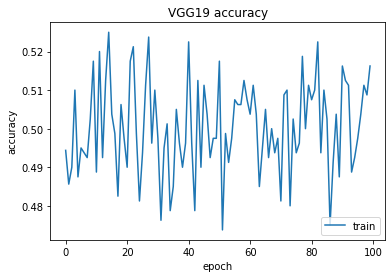

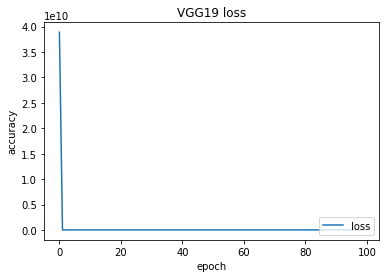

In [12]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('VGG19 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_accuracy'])
plt.title('VGG19 loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'test'], loc='lower right')
plt.show()

In [13]:
df = pd.DataFrame()
for idx, key in enumerate(history.history.keys()):
    row = pd.DataFrame(data={
      'item': key,
      'max': max(history.history[key]),
      'mean': np.mean(history.history[key]),
      'min': min(history.history[key]),
      'std': np.std(history.history[key]),
    }, index=[idx])
    df = pd.concat([df,row])

from IPython.display import HTML
df.sort_values(by=['item'],ascending=True)
HTML(df.to_html(index=False))

item,max,mean,min,std
loss,3.890037e+10,3.890037e+08,0.69599,3.870538e+09
accuracy,5.250000e-01,5.003500e-01,0.47375,1.182599e-02
true_positives,5.600000e+02,4.266400e+02,284.00000,4.790794e+01
true_negatives,4.960000e+02,3.739200e+02,260.00000,4.605555e+01
false_positives,5.280000e+02,4.140800e+02,292.00000,4.605555e+01
false_negatives,5.280000e+02,3.853600e+02,252.00000,4.790794e+01
